!kaggle competitions download -c titanic

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd ../gdrive/MyDrive/Kaggle/titanic/titanic_kaggle

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/Kaggle/titanic/titanic_kaggle


In [2]:
!ls

dataset       img      process_data.py	README.md
gitupload.sh  LICENSE  __pycache__	titanic_study.ipynb


# Background
Understand the relationship between the circuntances and the outcome, that finished the life of 549 human lifes. What characterized to the people, why they survived and what factors pushed his probabilities to survive are the main question that i going to review in this notebook.

## Project Planning
    * bonus automatic EDA

* Understand the data behavior <p>
  1 Histograms<p>
  2 Value counts <p>
  3 Missing data<p>
  4 correlations of some features
* Explore interesting themes <p>
  1 Rich people survive more?<p>
  2 Female survive more?, what about kids and old people<p>
  3 How the fare payment affects the survival<p>
  4 Your title name affects your chances to survive<p>
  5 Where did you embarked affects your chance to survive<p>
* Feature Engineering
    * Create more features
    * Fill nan values
    * Normalize data
    * Try to categorize data and see what happened ¿is good?
* Preprocess data for numerical and categorical data
* Understand the limitations of the data – imbalance data
* Model tunning
* Model benchmark

# Type of data

### 1 Numerical Data
* Histograms to understand distributions
* Correlations plot
* Pivot tables comparing survival rates

### 2 Categorical Data
* Made barchars to understand balance between classes
* Made pivot tables to understand relationship with survival

In [ ]:
!pip install autoviz

In [5]:
from process_data import pre_process_dataset, balancingClasses_Smoteenn, balancingClasses_Smote

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import random
import time
from tqdm import tqdm
import IPython.display as ipd
import seaborn as sns
import itertools
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV , RandomizedSearchCV
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import StratifiedKFold, KFold,cross_val_score
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.neighbors import NeighborhoodComponentsAnalysis as NCA
from sklearn.neighbors import KNeighborsClassifier as KNC
from IPython.display import display # display from IPython.display
import pandas_profiling # library for automatic EDA # pip install pandas-profiling[notebook]
from autoviz.AutoViz_Class import AutoViz_Class

%matplotlib inline
def plot_confusion_matrix(y_true, y_pred, class_names,title="Confusion matrix",normalize=False,onehot = False, size=4):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    if onehot :
        cm = confusion_matrix([y_i.argmax() for y_i in y_true], [y_ip.argmax() for y_ip in y_pred])
    else:
        cm = confusion_matrix(y_true, y_pred)
    figure = plt.figure(figsize=(size, size))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2) if normalize else cm

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "red" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    #return figure

Imported AutoViz_Class version: 0.0.68. Call using: 
    from autoviz.AutoViz_Class import AutoViz_Class
    AV = AutoViz_Class()
    AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)
            
To remove previous versions, perform 'pip uninstall autoviz'


In [2]:
DBtrain = pd.read_csv('dataset/train.csv')
DBtest = pd.read_csv('dataset/test.csv')
DBtrain.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Dumb Automatic EDA

Plots by pandas_profiling

report_easy = pandas_profiling.ProfileReport(DBtrain)
display(report_easy)

Let's now visualize the plots generated by AutoViz.

AV = AutoViz_Class()
report_2 = AV.AutoViz("dataset/train.csv")

# EDA
______________________________________________

We goint to explorate our data looking for relationships and some correlations with the survivors
* Missing Values
* Repeating values
* Histogram visualization (Normal distribution)
* Correlation into numerical data and survivors
* Barchar to visualize categorical data, to study the relevance of every category

###  EDA -  Missing Values
We can see there are missing values in Age, Embarked and Cabin, but this last one, is not necessarily a missing value. Cabin means, what cabins a passenger bought, naturately not all passenger can affort a cabin.<br>
**Procedimiento**<br>
Fill nan values, imputing data with mean values group in Sex, Pclass and Embarked

In [6]:
# Numerical Data
DBtrain.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Here we can see that son features have high ratio of repetitive like Ticket, maybe is a bad idea analy this feature, but for the problem we are going to analyzing and see how behave.

**Procedimiento**<br>
Analizar las caracteristicas internas de Ticket, in Feature Engineering Sections


In [7]:
DBtrain.describe(include=['object'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Levy, Mr. Rene Jacques",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644


Analising the data we can see that the categorical and numerical data can group in this way.

In [8]:
DBtrain_num = ['Age', 'SibSp', 'Parch', 'Fare']
DBtrain_cat = ['Sex', 'Ticket', 'Cabin', 'Embarked', 'Survived','Pclass']

### EDA - Visualizing histograms for numerical data
We can see that, Age is pretty normalize, but SibSP, Parch concentrate values of zero(0) value, 
We can see that Fare haven't a normal distribution, but i think that i could normalize, apply some matematical operatión to his values

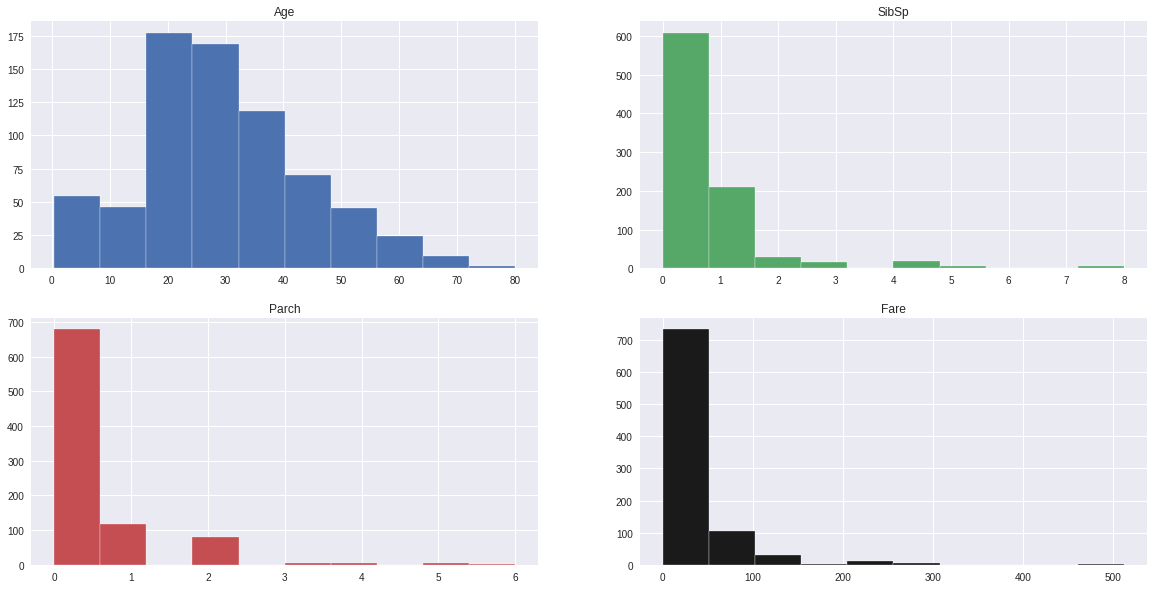

In [9]:
rcParams['figure.figsize'] = 20, 10
fig, axes = plt.subplots(nrows=2, ncols=2)
colors = ['b', 'g', 'r', 'k']
n_bins = None
for n, zippack in enumerate(zip(axes.flatten(), DBtrain_num)):
    axhist , i_label = zippack
    axhist.hist(DBtrain[i_label],bins=n_bins, histtype='bar',color=colors[n] ,density =None)
    axhist.set_title(i_label)

We can see that Age and Fare, have multiples values, maybe we can create bands of values and see probability behavior of survive

* We can create bands in Age <br>
There are not a perfect lenght for discretize the Age, but 5 look pretty good, for diferenciate probalistic beteeen bands, more bands, generate almos equal probality in intemedian ages

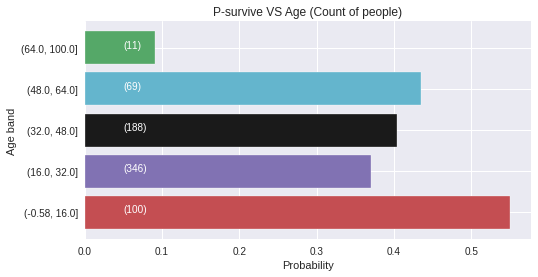

In [10]:
rcParams['figure.figsize'] = 8, 4
color = ['r','m','k','c','g']
n_bins = 5
f=plt.figure()
ax=f.add_subplot(1,1,1)
height = 1
DBtrain['AgeBand'] = pd.cut(DBtrain['Age'], [min(0,DBtrain['Age'].min()-1),16,32,48,64,max(100,DBtrain['Age'].max())])
ageband_surc= DBtrain[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False ).mean().sort_values(by='AgeBand', ascending=True)
ageband_surc['AgeBand'] = ageband_surc['AgeBand'].astype(str)

ageband_count = DBtrain[['AgeBand', 'PassengerId']].groupby(['AgeBand'], as_index=False ).count().sort_values(by='AgeBand', ascending=True)

ax.barh(y=ageband_surc['AgeBand'],width=ageband_surc['Survived'], color=color)
ax.set_xlabel('Probability')
ax.set_ylabel('Age band')
ax.set_title('P-survive VS Age (Count of people)')
_ = [ax.text(0.05,height*ind, '('+str(ageband_count['PassengerId'][ind])+')',color='w') for ind in range(len(ageband_surc))]

* We can analize Fare groups vs bands <br>
we can see clearly that more wealthy you are, more probability of survive, but around 170-426 the probability didn't change to much
But if we only use 3 bins, the difference increases drastically, we could see a rate ~ x2 for every range, i mean ~ 0.38, 0.65, 1 in p-survive, unfortunately who survive depend on the wealthiness.

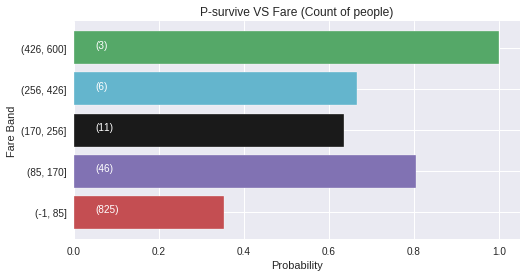

In [11]:
rcParams['figure.figsize'] = 8, 4
color = ['r','m','k','c','g','r','m','k','c','g','r','m','k','c','g']
f=plt.figure()
ax=f.add_subplot(1,1,1)
DBtrain['FareBand'] = pd.cut(DBtrain['Fare'], [min(-1,DBtrain['Fare'].min()),85,170,256,426,max(600,DBtrain['Fare'].max())])
fareband_count = DBtrain[['FareBand', 'PassengerId']].groupby(['FareBand'], as_index=False ).count().sort_values(by='FareBand', ascending=True)
fareband_surv = DBtrain[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False ).mean().sort_values(by='FareBand', ascending=True)
fareband_surv['FareBand'] = fareband_surv['FareBand'].astype(str)
ax.barh(y=fareband_surv['FareBand'],width=fareband_surv['Survived'], color=color)
ax.set_xlabel('Probability')
ax.set_ylabel('Fare Band')
ax.set_title('P-survive VS Fare (Count of people)')
_ = [ax.text(0.05,height*ind,'('+str(fareband_count['PassengerId'][ind])+')',color='w') for ind in range(len(ageband_surc))]

### EDA - Correlation between numerical features
From this study, we can infare that SibSp and Parch are a quite correlated, so we may fusion those variables into a single one, that indicate about, how alone or acoompained is a passenger, maybe infuence his survival

            Age     SibSp     Parch      Fare
Age    1.000000 -0.308247 -0.189119  0.096067
SibSp -0.308247  1.000000  0.414838  0.159651
Parch -0.189119  0.414838  1.000000  0.216225
Fare   0.096067  0.159651  0.216225  1.000000


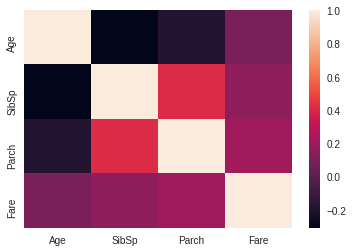

In [12]:
rcParams['figure.figsize'] = 6, 4
coor_matrix = DBtrain[DBtrain_num].corr()
print(coor_matrix)
_ = sns.heatmap(coor_matrix)

### EDA - Mean Values for every num_val VS Survived
We can see 
* more young more probability to survive
* more wealthy more chance to survive
* About Parch and SibSP is not so clear, but i think that is a little indicator to more parents more chance to live<br>

Before we saw that in every band of Age and Fare this results are very correlated

In [13]:
pd.pivot_table(DBtrain, index= 'Survived',values= DBtrain_num,aggfunc=['mean' ])

mean                               
                Age       Fare     Parch     SibSp
Survived                                          
0         30.626179  22.117887  0.329690  0.553734
1         28.343690  48.395408  0.464912  0.473684

### EDA - Barchar for categorical Data
we can see<p>
-the population of male are more bigger that female<p>
-the embarker C is more frecuenly<p>
-the 3thr class is the mayority of the passenger<p>
-Ticket and Cabin are not grouped so they can't be categorized in his raw form<p>
-Imbalance data set to classify survivor, could produce imbalance model, 549 deads vs 342 survivors

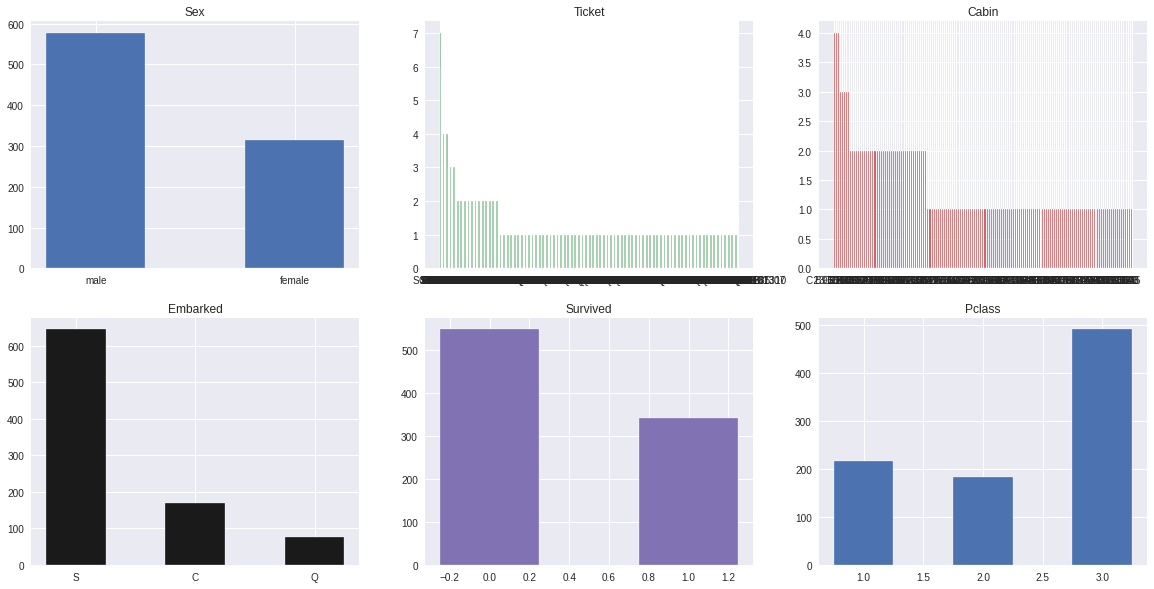

In [14]:
rcParams['figure.figsize'] = 20, 10
fig, axes = plt.subplots(nrows=2, ncols=3)
colors = ['b', 'g', 'r', 'k','m','b']
for n, zippack in enumerate(zip(axes.flatten(), DBtrain_cat)):
    axhist , i_label = zippack
    axhist.bar(DBtrain[i_label].value_counts().index.astype('object'), DBtrain[i_label].value_counts(),color=colors[n],width=0.5)
    axhist.set_title(i_label)

### EDA - Relationship between every categorical data and survival rate
We visualice some relation between survivers and his conditions in the journy
* Females survive more that males
* Embarker C have more survivors
* Class 1 have more survivors <p>

We may say that this result is because,
1. Money, Unfortunately is a factor
2. The place where they out,
3. "Women and children first" [wiki](https://en.wikipedia.org/wiki/Women_and_children_first)

In [15]:
def plot_bar_figure(label, data, xlabel, ylabel, title, rot='h', text =None, text_label=None, figsize = (10,2), colortext='w',heightText=0.07):
#     def get_ax_size(ax):
#         bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#         width, height = bbox.width, bbox.height
#         #width *= fig.dpi
#         #height *= fig.dpi
#         return width, height
    #rcParams['figure.figsize'] = 10, 2
    color = ['r','m','k','c','g','r','m','k','c','g','r','m','k','c','g']
    f=plt.figure(figsize=figsize)
    ax=f.add_subplot(1,1,1)
    if rot == 'h':
        ax.barh(y=label,width =data,color = [color[color_i] for color_i in range(len(label))])
        _= [ax.text(0.1,i+heightText, '('+str(text[i])+')', color = colortext) for i in range(len(text))] if not text is None else 0
    elif rot == 'v':
        ax.bar(x=label,height =data,color = [color[color_i] for color_i in range(len(label))])
        _= [ax.text(i+heightText,1, '('+str(text[i])+')', color = colortext) for i in range(len(text))] if not text is None else 0
    ax.set_xlabel(xlabel) 
    ax.set_ylabel(ylabel)
    ax.set_title(title) if text_label == None else ax.set_title(title+ " ("+text_label+")") 

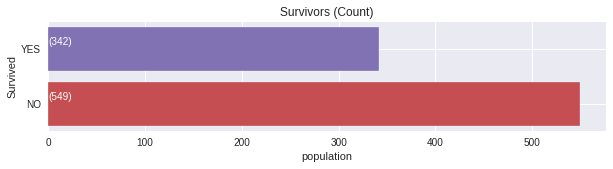

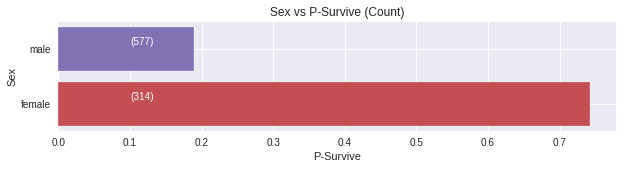

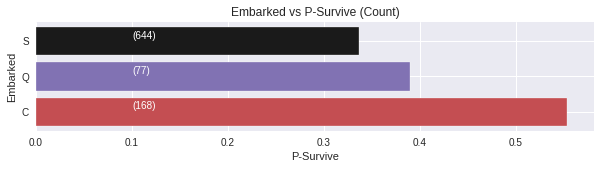

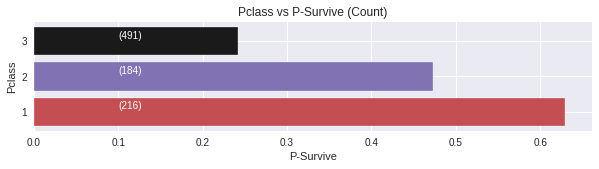

In [16]:
not_pivot = ['Survived','Ticket', 'Cabin' ]


survivors = pd.pivot_table(DBtrain, index= 'Survived',values= 'Ticket',aggfunc=['count'])
plot_bar_figure(label = ['NO', 'YES'], # survivors.index, #
                data =survivors['count']['Ticket'], 
                xlabel= 'population', 
                ylabel='Survived', 
                title='Survivors', 
                text = survivors['count']['Ticket'], rot='h',text_label='Count')

for i_label in DBtrain_cat:
    if i_label not in not_pivot:
        pivot_table = pd.pivot_table(DBtrain, index= i_label,values= 'Survived',aggfunc=['mean','count'])
        #display(pivot_table)
        text = pivot_table['count']['Survived'].tolist() 
        plot_bar_figure(label = pivot_table['mean'].index.astype(str),#survivors.index, 
                        data =pivot_table['mean']['Survived'], 
                        xlabel= 'P-Survive', 
                        ylabel=i_label, 
                        title=i_label + ' vs '+'P-Survive', 
                        text = text , rot='h',text_label='Count'  )

# FE - Feature Engineering
___________________________

#### Augmented Features
* Create a new feature from study Parch and SibSp
* Transform cabin string feature into a number that represent how many cabins a passager bought
* Take more features, asumming that one person bought all cabin with the same firts word, so we can know what "cabin Type" bought a passenger
* Take more features from the "Name" feature, we goint to see if the title name is relevant to determine if someone survive
* Study the posibility to extract some features form "Ticket"
* Fill nan values
* Normalizing Data
________________________________

### FE - Create a new feature from study Parch and SibSp
Just like we say in EDA, we can see a correlatión between Parch and SibSp, so we can create a single feature that resumen and could be more afective.

We know that bouth feature are relatave with how much familiar companied do you have in the ship, so we can summaize bouth feature into just one.

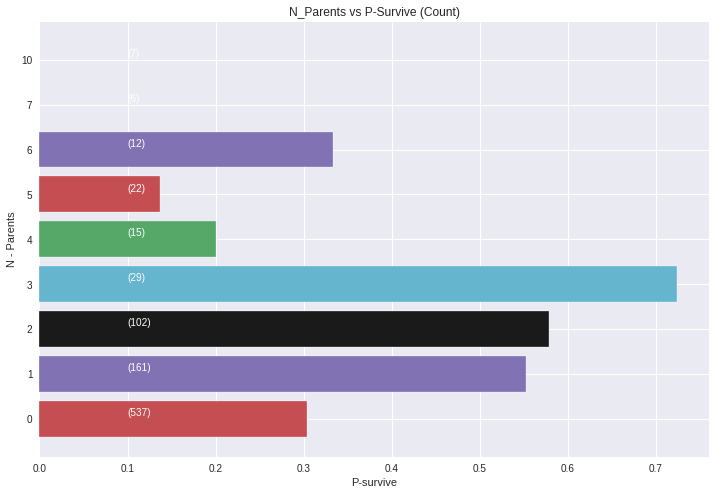

In [17]:
DBtrain['n_parents'] = DBtrain['SibSp'] + DBtrain['Parch']
nParents_surv = pd.pivot_table(DBtrain, index= 'n_parents' ,values= 'Survived',aggfunc=['mean', 'count'])

plot_bar_figure(label = nParents_surv['mean'].index.astype(str),
                data = nParents_surv['mean']['Survived'],
                xlabel = 'P-survive',
                ylabel = 'N - Parents', 
                title= 'N_Parents vs P-Survive', 
                text = nParents_surv['count']['Survived'].tolist(),
                text_label = 'Count',colortext='w',
                figsize = (12,8))

In [ ]:
DBtrain.head()

We see so many categories that destroy visivility, so we try transforming all categories into just 2, or you are accompanied or alone.
* if you are accompanied your chances to survive increase around to 50%


In [19]:
DBtrain['accompanied'] = DBtrain['n_parents'].apply(lambda x: x if x <7 else 'nn') #(lambda x: 1 if x >0 else 0) 
_ = pd.pivot_table(DBtrain, columns= 'accompanied', index= 'Survived',values= 'PassengerId',aggfunc='count')
print(_)

accompanied      0     1     2     3     4     5    6    nn
Survived                                                   
0            374.0  72.0  43.0   8.0  12.0  19.0  8.0  13.0
1            163.0  89.0  59.0  21.0   3.0   3.0  4.0   NaN


### FE - Exploring what is Cabin, 
we can see that not everyone buy for a cabin, but some wealthy people bought more than one cabin

We can supose that the name of the cabins dosen't matter. I think that only mather the quantity of cabin that a people buy,
that could be related whit his wealthiness.
For other hand, we can study that the first letter, in the cabin name, could have some importance over the survivors, maybe its location on the ship.

In [20]:
# Count how many cabins a passenger bought
DBtrain['Count_Cabin'] = DBtrain['Cabin'].apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
#DBtrain['Count_Cabin'].value_counts()

# Categorizing which type of cabin a passenger bought
DBtrain['w_Cabin'] = DBtrain['Cabin'].apply(lambda x: 'nn' if pd.isna(x) else x[0])
#DBtrain['w_Cabin'].value_counts() 

DBtrain[['Cabin','Count_Cabin','w_Cabin']].sort_values('Count_Cabin')

,Cabin,Count_Cabin,w_Cabin
0,NaN,0,nn
548,NaN,0,nn
549,NaN,0,nn
551,NaN,0,nn
552,NaN,0,nn
...,...,...,...
341,C23 C25 C27,3,C
27,C23 C25 C27,3,C
679,B51 B53 B55,3,B
311,B57 B59 B63 B66,4,B


We see that the way majority of the passengers not bought a single Cabin, so now we pretend to categorice the cabins, this will create inacurrate data for the model, instead we could only extract only two categories, 
* The passenger bought or not a cabin

In [22]:
# We will see the relationship between survivors and the number of cabin that bought
_ = pd.pivot_table(DBtrain, columns= 'Count_Cabin', index= 'Survived',values= 'Ticket',aggfunc='count')
display(_)
print("______________________")
# we will see the relationship between survivors and the type of cabin that they bought
_ = pd.pivot_table(DBtrain, columns= 'w_Cabin', index= 'Survived',values= 'Ticket',aggfunc='count')
display(_)

Count_Cabin,0,1,2,3,4
Survived,,,,,
0,481.0,58.0,7.0,3.0,NaN
1,206.0,122.0,9.0,3.0,2.0


______________________


w_Cabin,A,B,C,D,E,F,G,T,nn
Survived,,,,,,,,,
0,8.0,12.0,24.0,8.0,8.0,5.0,2.0,1.0,481.0
1,7.0,35.0,35.0,25.0,24.0,8.0,2.0,NaN,206.0


* The passenger bought a cabin yes or not

Text(0.5, 1.0, 'Survivor vs Population - Bought a Cabin')

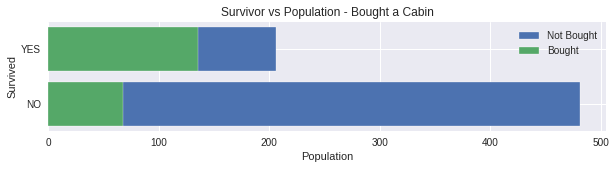

In [23]:
# The passenger bought a cabin yes or not
DBtrain['b_Cabin'] = DBtrain['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)
boughtCabin_survive = pd.pivot_table(DBtrain, columns= 'b_Cabin', index= 'Survived',values= 'Ticket',aggfunc='count')
color = ['r','m','k','c','g','r','m','k','c','g','r','m','k','c','g']
f=plt.figure(figsize=(10,2))
ax=f.add_subplot(1,1,1)
ax.barh(y=['NO', 'YES'],width =boughtCabin_survive[0])
ax.barh(y=['NO', 'YES'],width =boughtCabin_survive[1])
ax.legend(['Not Bought', 'Bought'])
ax.set_xlabel('Population')
ax.set_ylabel('Survived')
ax.set_title('Survivor vs Population - Bought a Cabin') 

### FE - Extracting features from Name
We going to extract the name title from every passenger, I think that is relative with his social posición and his gender, maybe is a condition that affect his survival

We see that exist 4 predominant titles name, so can group all passanger into this group, changing the less predomint to others

In [24]:
DBtrain['title_Name'] = DBtrain['Name'].apply(lambda x: x.split(',')[1:][0].split('.')[0].strip())
DBtrain['title_Name'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Mlle              2
Col               2
Sir               1
Jonkheer          1
Capt              1
the Countess      1
Ms                1
Mme               1
Don               1
Lady              1
Name: title_Name, dtype: int64

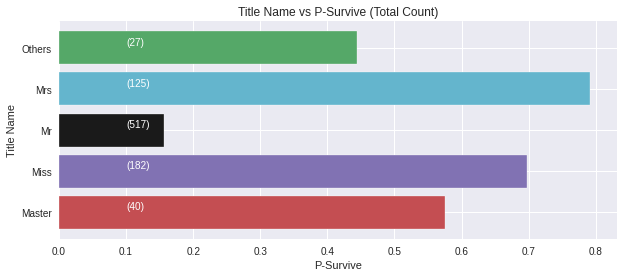

In [25]:
# Grouping title names using only the predominants
title_pred = ['Mr', 'Miss', 'Mrs','Master']
DBtrain['title_Name'] = DBtrain['title_Name'].apply(lambda x: x if x in title_pred else 'Others')
titleName_survi = pd.pivot_table(DBtrain, index= 'title_Name',values= 'Survived',aggfunc=['mean', 'count'])
#display(titleName_survi)
plot_bar_figure(label = titleName_survi.index.tolist() , 
                data= titleName_survi['mean']['Survived'] , 
                xlabel = 'P-Survive' , 
                ylabel = 'Title Name' , 
                title = 'Title Name vs P-Survive' , 
                text =titleName_survi['count']['Survived'], 
                text_label= 'Total Count' , 
                figsize = (10,4), 
                colortext='w',heightText=0.07)

### FE - Studing the Ticket
I studied the numerical and the no numerical mix Ticket, and try to find some relation in survival rate, but we found that is too random to be useful. I decided to drop that feature.

In [28]:
# We goint to pretend that there is a relatión between the ticket ID and the survivors
#   We take two new features
#      1. If a ticket is a number, change to 1
#      2. If a ticket start with a letter, take that string of letters. This technique is so risky, because in our test set could be a new string and will be in trouble
countbyTicket = DBtrain['Ticket'].value_counts()#.sort_values(ascending = False)
DBtrain['num_Ticket'] = DBtrain['Ticket'].apply(lambda x: 1 if x.isnumeric() else 0)
DBtrain['word_Ticket'] = DBtrain['Ticket'].apply(lambda x: x.split(' ')[0].replace('.', '').replace('/','').lower() if not x.split(' ')[0].isnumeric() else 0)
#print(DBtrain['num_Ticket'].value_counts())
#print(DBtrain['word_Ticket'].value_counts())
_ = pd.pivot_table(DBtrain, columns= 'num_Ticket', index= 'Survived',values= 'Ticket',aggfunc='count')
display(_)
_ = pd.pivot_table(DBtrain, columns= 'word_Ticket', index= 'Survived',values= 'Ticket',aggfunc='count')
display(_)

num_Ticket,0,1
Survived,,
0,142,407
1,88,254


word_Ticket,0,a4,a5,as,c,ca,casoton,fa,fc,fcc,line,pc,pp,ppp,sc,sca4,scah,scow,scparis,soc,sop,sopp,sotono2,sotonoq,sp,stono,stono2,swpp,wc,wep
Survived,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,407.0,7.0,19.0,1.0,3.0,27.0,1.0,1.0,1.0,1.0,3.0,21.0,1.0,1.0,NaN,1.0,1.0,1.0,6.0,5.0,1.0,3.0,2.0,13.0,1.0,7.0,3.0,NaN,9.0,2.0
1,254.0,NaN,2.0,NaN,2.0,14.0,NaN,NaN,NaN,4.0,1.0,39.0,2.0,1.0,1.0,NaN,2.0,NaN,5.0,1.0,NaN,NaN,NaN,2.0,NaN,5.0,3.0,2.0,1.0,1.0


 We can't see any relationship, even those repeat more than 20%
 * We can drop Ticket Feature

In [29]:
DBtrain=DBtrain.drop(columns=['Ticket','num_Ticket','word_Ticket'])

### FE - Fill Nan values
Like humans we can't see the whole data in a single look, to achieve we aggregate data, reading the count, uniquisity and distribution behavior of the data.

That exactly what we goint to do next

* Behavior of categorical data

In [30]:
DBtrain.describe(include=['object','category'])

,Name,Sex,Cabin,Embarked,AgeBand,FareBand,accompanied,w_Cabin,title_Name
count,891,891,204,889,714,891,891,891,891
unique,891,2,147,3,5,5,8,9,5
top,"Levy, Mr. Rene Jacques",male,B96 B98,S,"(16.0, 32.0]","(-1, 85]",0,nn,Mr
freq,1,577,4,644,346,825,537,687,517


* Behavior of numerical data
    * we detect that Some values of Fare are 0 ¿? could be an error or a gifs

In [31]:
DBtrain.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,n_parents,Count_Cabin,b_Cabin
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.904602,0.267116,0.228956
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,1.613459,0.547134,0.420397
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000,0.000000,0.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000,0.000000,0.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,10.000000,4.000000,1.000000


In [ ]:
DBtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
AgeBand        714 non-null category
FareBand       876 non-null category
n_parents      891 non-null int64
accompanied    891 non-null object
Count_Cabin    891 non-null int64
w_Cabin        891 non-null object
b_Cabin        891 non-null int64
title_Name     891 non-null object
dtypes: category(2), float64(2), int64(8), object(7)
memory usage: 120.7+ KB


* We see that AGe have Nan values, so we have to impute data (mean)
* We see thar Embarked have Nan Values, so we have to imute data categorical (moda)
* Cabin habe only 204 values, but we already study this feature

* Age => complete the nan values with mean value
* Embarked => Complete the nan values with the mode, which is S

In [33]:
DBtrain['Embarked'].mode()[0]

'S'

We take the "Age" media value using Sex and Pclass, to fill the nan values in Age feature

In [34]:
media_age = DBtrain.dropna(subset=['Age'])[['Age','Pclass','Sex','Embarked']].groupby(['Pclass','Sex','Embarked'], as_index=False ).mean().sort_values(by='Age', ascending=True)
def impute_years(x):
    if x['Age'] == x['Age']:
        return x['Age']
    else:
        return media_age.loc[media_age['Pclass']==x['Pclass'] , ['Age', 'Sex','Embarked']].loc[media_age['Sex']==x['Sex'] , ['Age','Embarked']].loc[media_age['Embarked']==x['Embarked'] , ['Age']]['Age'].tolist()[0]

In [36]:
DBtrain['Embarked'] = DBtrain['Embarked'].fillna(DBtrain['Embarked'].mode()[0])
DBtrain['Age'] = DBtrain.apply(impute_years, axis=1)# DBtrain['Age'].fillna( DBtrain['Age'].mean())
DBtrain['AgeBand'] = pd.cut(DBtrain['Age'], [min(0,DBtrain['Fare'].min()),16,32,48,64,max(100,DBtrain['Age'].max())])
DBtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    object  
 4   Sex          891 non-null    object  
 5   Age          891 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Fare         891 non-null    float64 
 9   Cabin        204 non-null    object  
 10  Embarked     891 non-null    object  
 11  AgeBand      891 non-null    category
 12  FareBand     891 non-null    category
 13  n_parents    891 non-null    int64   
 14  accompanied  891 non-null    object  
 15  Count_Cabin  891 non-null    int64   
 16  w_Cabin      891 non-null    object  
 17  b_Cabin      891 non-null    int64   
 18  title_Name   891 non-null    o

### FE - Normalizing Data
We saw that we could normalize the fare value, so we will try take the log10 to the fare value and see how it behaves

The transform result pretty useful, delivering a good normal distributión

Text(0.5, 1.0, 'Fare normalized')

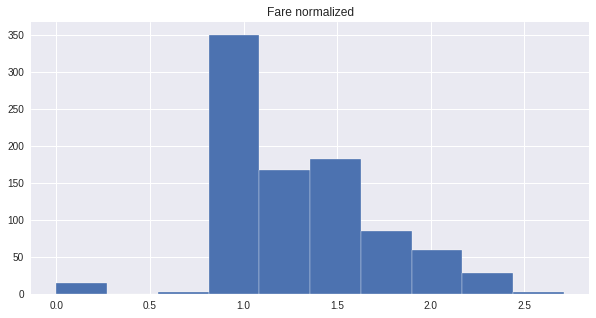

In [37]:
# On "Histogram for numerical Data" we saw that "Fare" is not normalize, the distance between his values are significance
#     We try to normalize that data, taken the logarithm10 to those values
rcParams['figure.figsize'] = 10, 5
DBtrain['norm_Fare']= DBtrain['Fare'].apply(lambda x : np.log10(x+1))
#DBtrain['norm_Fare']= DBtrain['norm_Fare']
DBtrain['norm_Fare'].hist().set_title('Fare normalized')
# we can see that the histogram look like a normal distributions more accurate

# Pre-processing data to Train Models
Because we have categorical data, we need to transform all the categorical data into arrays that our model can interpretate,
we can use pd.dummies or hot-encode, in this case are equal, also we need to drop the columns that we dont use anymore

In [38]:
DBtrain.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,AgeBand,FareBand,n_parents,accompanied,Count_Cabin,w_Cabin,b_Cabin,title_Name,norm_Fare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S,"(16, 32]","(-1, 85]",1,1,0,nn,0,Mr,0.916454
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C,"(32, 48]","(-1, 85]",1,1,1,C,1,Mrs,1.859038


* Data set modeling with all feature categorical

In [ ]:
# Second Test
DBtrain_f = DBtrain.copy()
DBtrain_f.index  = DBtrain_f.PassengerId
DBtrain_f = DBtrain_f.drop(columns=[ 'Cabin','Fare','Name','PassengerId','w_Cabin', 'Count_Cabin','n_parents','SibSp','Parch','norm_Fare','Age'])
DBtrain_f['Pclass'] = DBtrain_f['Pclass'].astype(str) # categorical feature
DBtrain_f['accompanied'] = DBtrain_f['accompanied'].astype(str) # categorical feature
DBtrain_f['b_Cabin'] = DBtrain_f['b_Cabin'].astype(str) # categorical feature
DBtrain_f['AgeBand'] = DBtrain_f['AgeBand'].astype(str) # categorical feature
DBtrain_f['AgeBand'] = DBtrain_f['AgeBand'].apply(lambda x : x.replace('(','').replace(']','').replace(',','_'))
DBtrain_f['FareBand'] = DBtrain_f['FareBand'].astype(str) # categorical feature
DBtrain_f['FareBand'] = DBtrain_f['FareBand'].apply(lambda x : x.replace('(','').replace(']','').replace(',','_'))
DBtrain_f.info()
DBtrain_f.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 9 columns):
Survived       891 non-null int64
Pclass         891 non-null object
Sex            891 non-null object
Embarked       891 non-null object
AgeBand        891 non-null object
FareBand       891 non-null object
accompanied    891 non-null object
b_Cabin        891 non-null object
title_Name     891 non-null object
dtypes: int64(1), object(8)
memory usage: 69.6+ KB


,Survived,Pclass,Sex,Embarked,AgeBand,FareBand,accompanied,b_Cabin,title_Name
PassengerId,,,,,,,,,
1,0,3,male,S,16_ 32,0.0_ 85.0,1,0,Mr
2,1,1,female,C,32_ 48,0.0_ 85.0,1,1,Mrs
3,1,3,female,S,16_ 32,0.0_ 85.0,0,0,Miss
4,1,1,female,S,32_ 48,0.0_ 85.0,1,1,Mrs
5,0,3,male,S,32_ 48,0.0_ 85.0,0,0,Mr


* Data set modeling with Age and Fare like numerical feature

In [41]:
# First test
DBtrain_f = DBtrain.copy()
DBtrain_f.index  = DBtrain_f.PassengerId
DBtrain_f = DBtrain_f.drop(columns=[ 'Cabin','Fare','Name','PassengerId','w_Cabin', 'Count_Cabin','SibSp','Parch', 'n_parents' ])
DBtrain_f['Pclass'] = DBtrain_f['Pclass'].astype(str) # categorical feature
DBtrain_f['accompanied'] = DBtrain_f['accompanied'].astype(str) # categorical feature
DBtrain_f['b_Cabin'] = DBtrain_f['b_Cabin'].astype(str) # categorical feature
DBtrain_f.info()
DBtrain_f.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Survived     891 non-null    int64   
 1   Pclass       891 non-null    object  
 2   Sex          891 non-null    object  
 3   Age          891 non-null    float64 
 4   Embarked     891 non-null    object  
 5   AgeBand      891 non-null    category
 6   FareBand     891 non-null    category
 7   accompanied  891 non-null    object  
 8   b_Cabin      891 non-null    object  
 9   title_Name   891 non-null    object  
 10  norm_Fare    891 non-null    float64 
dtypes: category(2), float64(2), int64(1), object(6)
memory usage: 71.8+ KB


,Survived,Pclass,Sex,Age,Embarked,AgeBand,FareBand,accompanied,b_Cabin,title_Name,norm_Fare
PassengerId,,,,,,,,,,,
1,0,3,male,22.0,S,"(16, 32]","(-1, 85]",1,0,Mr,0.916454
2,1,1,female,38.0,C,"(32, 48]","(-1, 85]",1,1,Mrs,1.859038
3,1,3,female,26.0,S,"(16, 32]","(-1, 85]",0,0,Miss,0.950608
4,1,1,female,35.0,S,"(32, 48]","(-1, 85]",1,1,Mrs,1.733197
5,0,3,male,35.0,S,"(32, 48]","(-1, 85]",0,0,Mr,0.956649


In [44]:
DBtrain_f = pd.get_dummies(DBtrain_f)
X_train = DBtrain_f.drop(columns='Survived')
Y_train = DBtrain_f['Survived']
DBtrain_f.head()

,Survived,Age,norm_Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,"AgeBand_(0, 16]","AgeBand_(16, 32]","AgeBand_(32, 48]","AgeBand_(48, 64]","AgeBand_(64, 100]","FareBand_(-1, 85]","FareBand_(85, 170]","FareBand_(170, 256]","FareBand_(256, 426]","FareBand_(426, 600]",accompanied_0,accompanied_1,accompanied_2,accompanied_3,accompanied_4,accompanied_5,accompanied_6,accompanied_nn,b_Cabin_0,b_Cabin_1,title_Name_Master,title_Name_Miss,title_Name_Mr,title_Name_Mrs,title_Name_Others
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,22.0,0.916454,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
2,1,38.0,1.859038,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
3,1,26.0,0.950608,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,1,35.0,1.733197,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
5,0,35.0,0.956649,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0


# Modeling - Improve imbalance data
we goint to see how well BalancedBaggingClassifier, we improve the model with imbalance method training
* 549 deads vs 342 survivors

| Model  | score  | 
|---|---|
| SVC  |    0.8488 |  
| XGB  | 0.8724 | 
| KNC  |   0.8979|
| RFC |    0.9344 |
| GBC |    0.8925|
| Voting XGB+KNC+RFC+SVC| 0.8970| 
| SKC XGB+KNC+RFC+SVC => XGB|  0.9089|

In [2]:
from process_data import pre_process_dataset, balancingClasses_Smoteenn, balancingClasses_Smote
X_train_all, Y_train_all = pre_process_dataset(all_categorical=False, Test=False, fillna_age = None)
X_train_all, Y_train_all = balancingClasses_Smote(X_train_all, Y_train_all ,random_state=12)

In C:\Users\David\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\David\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\David\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\David\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed tw

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    int64  
 1   Pclass       891 non-null    object 
 2   Sex          891 non-null    int64  
 3   Embarked     891 non-null    object 
 4   accompanied  891 non-null    object 
 5   b_Cabin      891 non-null    int64  
 6   title_Name   891 non-null    object 
 7   norm_Fare    891 non-null    float64
 8   norm_Age     891 non-null    float64
dtypes: float64(2), int64(3), object(4)
memory usage: 69.6+ KB
Count for each class value after SMOTE: Counter({0: 549, 1: 549})


## Parameter Optimization

In [3]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV , RandomizedSearchCV,StratifiedKFold
#from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier,ExtraTreesClassifier, StackingClassifier
from sklearn.model_selection import StratifiedKFold, KFold,cross_val_score
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import accuracy_score,confusion_matrix
#from sklearn import svm
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression as LR
from sklearn.decomposition import PCA
#from sklearn.neighbors import NeighborhoodComponentsAnalysis as NCA
from sklearn.neighbors import KNeighborsClassifier as KNC
from collections import defaultdict
from sklearn.metrics import classification_report

from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
best_parameters = defaultdict(list) # 'xgb': XGBClassifier(),
classifiers = defaultdict(list)
X_train, X_test, y_train, y_test = train_test_split(X_train_all, Y_train_all, test_size=0.2, random_state=133, stratify = Y_train_all)

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
# Parameters to tune
# SVC_simple
tuned_parameters_svc = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4, 'auto','scale'],'C': [1, 10, 100, 1000], 'probability': [True]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000], 'probability': [True]}]

# SVC
tuned_parameters_Linearsvc = [{'penalty': ['l2','l1'], 'loss': ['squared_hinge','hinge'],'C': [0.01,0.1,1.0,10], 'max_iter': [4000], 'random_state':[15], 'dual':[False]}]

# XGB
tuned_parameters_xgb = [{'learning_rate':[.2, 0.1, 0.02, 0.01],'n_estimators':[10,50,80,100,150,200],'min_child_weight':[0.1, 0.5, 1.0, 1.5],'subsample':[0.1, 0.5, 0.8, 1.0],'colsample_bytree':[0.5, 0.1, 0.2, 0.8, 1.0],
                    'objective':['multi:softmax','binary:logistic'],'n_jobs':[-1],'max_depth': [3,5,6,8,10,12] , 'gamma': [0.0, .1, .2, .3, .4, .5, 1.0]}]
#KNC
tuned_parameters_knc = [{'n_neighbors':[2,4,6,8,10,12],'n_jobs':[-1],'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],'p':[1,2]}]

#RFC
tuned_parameters_rfc = [{'n_estimators':[80,100,120,140,160],'criterion':['gini','entropy'],'min_samples_split':[1,2,3,4,5], 'max_depth':[3,5,8,10]}]

#GBC
tuned_parameters_gbc = [{'loss':['deviance','exponential'],'learning_rate':[0.1,0.01],'n_estimators':[80,100,120],'subsample':[.8,1.0],'criterion':[ 'mse','friedman_mse'],
                         'max_depth':[3,5,8,10]}]

#ETC
tuned_parameters_etc = [{ 'min_samples_split':[.2,.4,.8], 'n_estimators':[80,100,150],'warm_start':[True],'bootstrap':[True],'max_depth':[3,5,8,10],
                         'n_jobs':[-1], 'min_samples_leaf':[3,4,5,6] ,'criterion':['gini', 'entropy'],'max_features':[ 'sqrt']   }]

#LR
tuned_parameters_lr = [{'C':[0.1,1.0,10.0], 'dual':[False], 'solver':['newton-cg', 'saga','sag'],'multi_class':['ovr', 'multinomial']}]

# Parameter tunning
scores = {'f1': 'f1_macro', 'roc':'roc_auc_ovr' , 'prec': 'precision'}

# Best parameters

models = {'svc': SVC(), 'lr': LR(random_state=17), 'xgb': XGBClassifier(), 'rfc':RandomForestClassifier(), 'knc': KNC(),'etc':ExtraTreesClassifier() ,'gbc':GradientBoostingClassifier() }
parameters = {'lr':tuned_parameters_lr, 'xgb': tuned_parameters_xgb, 'knc': tuned_parameters_knc,'rfc':tuned_parameters_rfc, 'svc':tuned_parameters_svc, 'gbc':tuned_parameters_gbc, 'etc':tuned_parameters_etc }

#;ista = ['etc']
for model_name in models.keys():
    print("######### MODEL tunning hyper-parameters for %s" % model_name)
    print("# %s - Tuning hyper-parameters ###############################################################" % (model_name))
    clf_i = GridSearchCV(models[model_name], parameters[model_name], scoring=scores, refit = "f1"  , n_jobs=-1, cv=skf)
    clf_i.fit(X_train,y_train)
    print("Best parameters set found on development set:")
    print()
    print(clf_i.best_params_)
    best_parameters[model_name] = clf_i.best_params_
    classifiers[model_name] = clf_i
    print("Grid scores on development set:")
    print()
    means = clf_i.cv_results_["mean_test_prec"]
    # stds = clf_i.cv_results_['std_test_score']
#         for mean, std, params in zip(means, stds, clf_i.cv_results_['params']):
#             print("%s_macro - %0.3f (+/-%0.03f) for %r"% (score, mean, std * 2, params))
    print("Detailed classification report:")
    print("CV - Results max score: {}".format(np.nan_to_num( means).max()))
    print()
    y_true, y_pred = y_test, clf_i.predict(X_test)
    print(classification_report(y_true, y_pred, digits=4 ))

######### MODEL tunning hyper-parameters for svc
# svc - Tuning hyper-parameters ###############################################################


* BaggingClassifier

# Test perform
The test data contain Nans so, what i did was impute values, using the media, taking in consideration, Pclass, sex and Embarked
* Method below
* I create the file process_data.py where is the steps that i use for process all the test_Data

* Preprocessing Test data to submmit

In [6]:
#from process_data import pre_process_dataset
X_test, X_test_origin = pre_process_dataset(all_categorical=False, Test=True, fillna_age = None)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pclass       418 non-null    object 
 1   Sex          418 non-null    int64  
 2   Embarked     418 non-null    object 
 3   accompanied  418 non-null    object 
 4   b_Cabin      418 non-null    int64  
 5   title_Name   418 non-null    object 
 6   norm_Fare    418 non-null    float64
 7   norm_Age     418 non-null    float64
dtypes: float64(2), int64(2), object(4)
memory usage: 29.4+ KB


In [8]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sex                418 non-null    int64  
 1   b_Cabin            418 non-null    int64  
 2   norm_Fare          418 non-null    float64
 3   norm_Age           418 non-null    float64
 4   Pclass_1           418 non-null    uint8  
 5   Pclass_2           418 non-null    uint8  
 6   Pclass_3           418 non-null    uint8  
 7   Embarked_C         418 non-null    uint8  
 8   Embarked_Q         418 non-null    uint8  
 9   Embarked_S         418 non-null    uint8  
 10  accompanied_0      418 non-null    uint8  
 11  accompanied_1      418 non-null    uint8  
 12  accompanied_2      418 non-null    uint8  
 13  accompanied_3      418 non-null    uint8  
 14  accompanied_4      418 non-null    uint8  
 15  accompanied_5      418 non-null    uint8  
 16  accompanied_6      418 

In [ ]:
estmt = model_VC_hard.estimators
y_predict_xgb = estmt[0][1].predict(X_test)
y_predict_knc = estmt[1][1].predict(X_test)
y_predict_rfc = estmt[2][1].predict(X_test)
y_predict_svc = estmt[3][1].predict(X_test)
y_predict_vc = model_VC.predict(X_test)

y_predict_skc = model_SKC.predict(X_test)

In [ ]:
print("CLASSIF test: equal:"+ str(accuracy_score(y_predict_svc, y_predict_skc)))

CLASSIF test: equal:0.916267942583732


In [ ]:
submission_file = pd.DataFrame({ 'PassengerId':np.stack(X_test.index.tolist()),'Survived': y_predict_vc})
submission_file.to_csv('submission/submm_vc7.csv',index=False, )
submission_file = pd.DataFrame({ 'PassengerId':np.stack(X_test.index.tolist()),'Survived': y_predict_xgb})
submission_file.to_csv('submission/submm_xgb7.csv',index=False, )
submission_file = pd.DataFrame({ 'PassengerId':np.stack(X_test.index.tolist()),'Survived': y_predict_knc})
submission_file.to_csv('submission/submm_knc7.csv',index=False, )
submission_file = pd.DataFrame({ 'PassengerId':np.stack(X_test.index.tolist()),'Survived': y_predict_svc})
submission_file.to_csv('submission/submm_svc7.csv',index=False, )
submission_file = pd.DataFrame({ 'PassengerId':np.stack(X_test.index.tolist()),'Survived': y_predict_rfc})
submission_file.to_csv('submission/submm_rfc7.csv',index=False, )

submission_file = pd.DataFrame({ 'PassengerId':np.stack(X_test.index.tolist()),'Survived': y_predict_skc})
submission_file.to_csv('submission/submm_skc.csv',index=False, )